<a id='top'></a> 
# CHILD ML Analysis
    - ML Pipeline for CHILD Dataset from the very beginning

##### [Step One: Feature Selection Strategies (Insights)](#0)

##### [Step Two: Making ML Pipelines](#pipeline)

##### Step Three: Tunning & Feature Engineering/Selection (data review) to Improve Performance (Insights)

##### Step Four: Visualization of model performance

##### Step Five: Paper, Deployment

### Libraries

In [1]:
# Preferences of autoformatting & Multiple Output
%load_ext nb_black

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings

warnings.filterwarnings("ignore")

import researchpy as rp  # For auto-statistics/EDA of dataframe
from tqdm.notebook import tqdm  # For process display

import sys

sys.path.append("../src")

from data import *
from utils import *
from conf import *
from tools import *

import utils as UT

import random

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

<IPython.core.display.Javascript object>

### Data

In [2]:
# df_raw = generate_raw_xlsx()
df_child = load_child_with_more()

Loading ('../data/addon/Prenatal Q91PRNMH18WK.xlsx', '../output/CHILD_raw.xlsx', '../data/addon/breastfeeding data.xlsx', '../data/addon/Prenatal Q91PRNMH18WK.xlsx'), and merging
The dataframe merged with more information is saved to ../output/ with name of CHILD_with_addon.xlsx


<IPython.core.display.Javascript object>

In [ ]:
df_targeted = target_selector(df_child, target_mapping={2: 1})

In [ ]:
df_shrunk, X, y, df_dropped = sample_selector(df_targeted)

In [ ]:
# Restore raw data
df = df_shrunk.copy()
X = df_shrunk.drop(columns="y").copy()
y = df_shrunk["y"].copy()

###  Test Run of Transformers

In [ ]:
df_for_ml = generate_trainable_dataset(X, y, add_indicator_threshold=200)

In [ ]:
# Backup df_for_ml
df_for_ml_backup = df_for_ml.copy()

In [ ]:
df_for_ml.y.value_counts(normalize=True)
df_for_ml.y.value_counts(normalize=False)
# Restore X,y for ML modelling
X = df_for_ml.drop(columns="y")
y = df_for_ml.y
X.shape
y.shape

In [ ]:
# Scaled ML using MinMaxScaler()
df_ml_scaled = pd.DataFrame(
    MinMaxScaler().fit_transform(df_for_ml),
    columns=df_for_ml.columns,
    index=df_for_ml.index,
)

for i in df_ml_scaled.columns:
    df_ml_scaled[i] = df_ml_scaled[i].astype("float16")

X = df_ml_scaled.drop(columns="y")
y = df_ml_scaled.y
X.shape
y.shape

In [ ]:
df_ml_scaled

## Now begins the INTERESTING ML Journey!

In [ ]:
print(view_module_functions(UT))

In [ ]:
X_summary = df_summary(X)
X_summary.sort_values(by="Variance")

In [ ]:
y_prop = view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0)

view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0.5)[
    view_y_proportions(
        df_ml_scaled, df_ml_scaled.columns[:-1], 0.5
    ).Asthma_Proportion_over_thresh
    < 10
]

y_prop.loc["Prenatal_Hypotension"]

#### Statistic Analysis for F10min Mask related to Asthma Outcome

Pingouin, statsmodel(table,proportion), scipy, sklearn

In [ ]:
# Three Package to obtain P value for chi square test for F10min Oxygen Mask Stats
# Scipy Based
# One
import pingouin as pg

expected, observed, stats = pg.chi2_independence(
    df_ml_scaled, x="F10min_Oxygen_Mask", y="y", correction=False
)

observed, expected, stats

_, _, stats = pg.chi2_independence(
    df_ml_scaled, x="Prenatal_Hypotension", y="y", correction=False
)

stats

In [ ]:
# Two: Scipy - Required to create contingency table as input
# Need to create a contingency table first, which can be realized using pd.crosstab

from scipy.stats import chi2_contingency

contingency_f10m_Oxy = pd.crosstab(df_ml_scaled.F10min_Oxygen_Mask, df_ml_scaled.y)

chi2_contingency(contingency_f10m_Oxy.values, correction=False)

print(
    "In statistics, Yates's correction for continuity (or Yates's chi-squared test) is used in certain situations when testing for independence in a contingency table. It aims at correcting the error introduced by assuming that the discrete probabilities of frequencies in the table can be approximated by a continuous distribution (chi-squared). In some cases, Yates's correction may adjust too far, and so its current use is limited."
)

In [ ]:
# Three: Statsmodel
import statsmodels.api as sm

# sm_f10oxy_table = sm.stats.Table(contingency_f10m_Oxy.values)
sm_f10oxy_table = sm.stats.Table.from_data(df_ml_scaled[["F10min_Oxygen_Mask", "y"]])

print(f"Observed Table:\n {sm_f10oxy_table.table_orig}")
print(f"Expected Table:\n {sm_f10oxy_table.fittedvalues}")
print(
    f"Pearson Residuals:\n {sm_f10oxy_table.resid_pearson}"
)  # view Residuals which identify particular cells that most strongly violate independence

print("\n----------------Independence/Association test----------------")
print("\nNominal Association:\n", sm_f10oxy_table.test_nominal_association())
print("\nOrdinal Association:\n", sm_f10oxy_table.test_ordinal_association())
print(f"\nChi Square Contribution:\n{sm_f10oxy_table.chi2_contribs}")
print(
    "\n----------------Local Odd Ratio----------------:\n{}".format(
        sm_f10oxy_table.local_oddsratios
    )
)
print(
    f"Contingency table odd ratio: {sm.stats.Table2x2(contingency_f10m_Oxy.values).oddsratio}"
)


# Three-2: Statsmodel Proportion Test
# Proportion Chi-Square Test
print("\n----------------Proportion Chi-Square Test----------------")
from statsmodels.stats.proportion import (
    proportions_chisquare,
    proportion_effectsize,
)  # No indexing needed

f10mask_no_group_observation = np.sum(df_ml_scaled.F10min_Oxygen_Mask != 1)
f10mask_yes_group_observation = np.sum(df_ml_scaled.F10min_Oxygen_Mask == 1)

f10mask_no_asthma_count = np.sum(df_ml_scaled[df_ml_scaled.F10min_Oxygen_Mask != 1].y)
f10mask_yes_asthma_count = np.sum(df_ml_scaled[df_ml_scaled.F10min_Oxygen_Mask == 1].y)

(chi2, chi2_p_value, expected) = proportions_chisquare(
    count=[f10mask_no_asthma_count, f10mask_yes_asthma_count],
    nobs=[f10mask_no_group_observation, f10mask_yes_group_observation],
)

print(
    "\nAsthma Outcome Proportion Chi Square Test:\nchi2: %f \t p_value: %f"
    % (chi2, chi2_p_value)
)


asthma_no_group_observation = np.sum(df_ml_scaled.y != 1)
asthma_yes_group_observation = np.sum(df_ml_scaled.y == 1)

asthma_no_f10mask_count = np.sum(df_ml_scaled[df_ml_scaled.y != 1].F10min_Oxygen_Mask)
asthma_yes_f10mask_count = np.sum(df_ml_scaled[df_ml_scaled.y == 1].F10min_Oxygen_Mask)

(chi2, chi2_p_value, expected) = proportions_chisquare(
    count=[asthma_no_f10mask_count, asthma_yes_f10mask_count],
    nobs=[asthma_no_group_observation, asthma_yes_group_observation],
)

print(
    "\nF10m Mask Outcome Proportion Chisquare Test:\nchi2: %f \t p_value: %f"
    % (chi2, chi2_p_value)
)

In [ ]:
print("Discrepancy: P-value of chi square test between Scipy and Statsmodel")

print(
    f"\nFor Scipy with correction:\npvalue: {chi2_contingency(contingency_f10m_Oxy.values)[1]}"
)
print(
    f"\nFor Scipy without correction:\npvalue: {chi2_contingency(contingency_f10m_Oxy.values, correction=False)[1]}"
)

print(f"\nFor Statsmodel:\n{sm_f10oxy_table.test_nominal_association()}")


print(
    "\nExplanation:\n\nScipy uses the continuity correction, Statsmodels does not. If you pass correction=False to the scipy test, then the results will be identical."
)

In [ ]:
# Four: Sklearn - CHI2
from sklearn.feature_selection import chi2

chi2(df_ml_scaled.F10min_Mask_Ventilation.values.reshape(-1, 1), df_ml_scaled.y)

### ML Libraries

In [7]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Feature selection
from sklearn.feature_selection import (
    SelectPercentile,
    SelectKBest,
    SelectFwe,
    SelectFpr,
    SelectFromModel,
    chi2,
    mutual_info_classif,
    f_classif,
    SequentialFeatureSelector,
    RFECV,
)
from sklearn.inspection import permutation_importance

# Imbalance Learn
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression, Lasso, LassoLarsCV, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Ensemble
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Metrics, Parameters, Evaluation
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    train_test_split,
)


from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

### Feature Selection   <a id='0'></a> 

1. [Lasso](#lasso)
2. [Chi2](#chi2)
3. [f_value](#f_classif)
4. [FalsePositiveRate](#fpr)
5. [p_value](#fwe)
6. [mutual_information](#mutal)
7. [Recursive Feature Elimination](#RFE)
8. [SelectFromModel](#selm)
9. [permutation_importance](#permutation)
10. [SequentialFeatureSelector](#sequentialgreed)

### Feature Engineering
1. [PCA](#pca)
2. [FeatureAgglomeration](#clusteragglomeration)
3. [Derived_New_Features_with_Expertise_and_Logic](#derivenewfeature)

[return](#top)

#### (1) Lasso - Observation - 1

In [ ]:
# plt.style.available
# plt.style.use("seaborn-bright")

In [ ]:
# Automatic Alphas with StratifiedKfold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1015)
model = LassoLarsCV(cv=skf).fit(X, y)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
columns_of_total = X.shape[1]
start = 0
end = X.shape[1]
number_of_display = end - start

cm = iter(plt.get_cmap("Set1")(np.linspace(0, 1, number_of_display)))
for i in range(start, end):
    c = next(cm)
    _ = ax.plot(
        model.alphas_, model.coef_path_.T[:, i], c=c, alpha=0.8, label=X.columns[i]
    )


lassocv_df = pd.DataFrame(
    data=model.coef_path_.T, columns=X.columns, index=model.alphas_
)

y_pos_ser = lassocv_df.iloc[-1:].T.iloc[:, 0][lassocv_df.iloc[-1:].T.iloc[:, 0] != 0]
x_pos = float(lassocv_df.iloc[-1:].T.columns.values)
x_pos_list = [x_pos for i in range(len(y_pos_ser))]

for x_t, y_t, text in zip(x_pos_list, y_pos_ser.values, y_pos_ser.index):
    axtxt = ax.text(
        x_t - 0.00005,
        y_t,
        text,  # Used to format it K representation
        color="black",
        rotation="horizontal",
        size="large",
    )

ax.legend(X.columns[start:end], bbox_to_anchor=(1, 1))

plt.xlim([0.00028, 0.00125])
plt.ylabel("Lasso Regression CV")
plt.xlabel("Regularization Factor - Alphas")
plt.title("Regression Coefficient Progression for Lasso Path")

fig.savefig("../images/lasso_progression",dpi=300,bbox_inches='tight')


In [ ]:
view_y_proportions(
    df_for_ml, lassocv_df.sum()[lassocv_df.sum() != 0].sort_values().index, 0.5
)

#### Lasso - Observation - 2 - All features decreasing pattern   <a id='lasso'></a>

[return](#0)

In [ ]:
coef_dict = {}
for alp in tqdm(np.arange(0.000001, 0.0009, 0.000005)):
    lasso_model = Lasso(alpha=alp).fit(X, y)
    coef_dict[alp] = list(lasso_model.coef_)

res = pd.DataFrame(data=coef_dict.values(), columns=X.columns, index=coef_dict.keys()).T

In [ ]:
# For those with bitter coefficient (impact)
res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index
view_y_proportions(
    df_for_ml, res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index, 0.5
)

In [ ]:
# sns.color_palette("YlOrBr", as_cmap=True)
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(res.iloc[:, :], vmax=0.2, vmin=-0.2, cmap="vlag", ax=ax)

#### (2) Chi2 & SelectPercentile  <a id='chi2'></a>

[return](#0)

In [ ]:
clf = Pipeline([("chi2", SelectPercentile(chi2)), ("rfc", RandomForestClassifier())])

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1020)

In [ ]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 5, 10, 15, 20, 30, 40, 60, 80, 90, 100)

for percentile in tqdm(percentiles):
    clf.set_params(chi2__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=skf, scoring="roc_auc")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


plt.figure(figsize=(12, 8))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    "Performance of the RandomForest-Chi2 varying the percentile of features selected"
)
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Precision Score")
plt.axis("tight")
plt.show()

In [ ]:
chi_perc = SelectPercentile(chi2, percentile=30)
chi_perc.fit_transform(X, y)

In [ ]:
# X.columns[chi_perc.get_support()]
chi_perc.get_feature_names_out()
len(chi_perc.get_feature_names_out())

chi2_res = pd.DataFrame(
    [list(chi_perc.pvalues_), list(chi_perc.scores_)],
    index=["P_value", "Scores"],
    columns=X.columns,
).T

chi2_res[chi2_res.P_value < 0.05]

In [ ]:
view_y_proportions(df_ml_scaled, chi2_res[chi2_res.P_value < 0.05].index, 0)

#### (3) F_classif & SelectPercentile  <a id='f_classif'></a>

[return](#0)

In [ ]:
clf = Pipeline([("fvalue", SelectKBest(f_classif)), ("xgb", XGBClassifier())])

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1020)

In [ ]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
k_best = (10, 20, 25, 30, 35, 40, 50, 60, 70, 90, "all")

for i in tqdm(k_best):
    clf.set_params(fvalue__k=i)
    this_scores = cross_val_score(clf, X, y, cv=skf, scoring="roc_auc")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


plt.figure(figsize=(12, 8))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the XGB-f_value varying the number of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Precision Score")
plt.axis("tight")
plt.show()

In [ ]:
f_bestk = SelectKBest(f_classif, k=40)
f_bestk.fit_transform(X, y)

f_bestk.get_feature_names_out()
len(f_bestk.get_feature_names_out())

f_res = pd.DataFrame(
    [list(chi_perc.pvalues_), list(chi_perc.scores_)],
    index=["P_value", "Scores"],
    columns=X.columns,
).T

f_res[f_res.P_value < 0.05]

f_res[f_res.Scores > 5]

#### (4) False Positive Rate  <a id='fpr'></a>

[return](#0)

In [ ]:
fpr_res = SelectFpr(score_func=chi2, alpha=0.15)
fpr_res.fit_transform(X, y).shape
col_temp = (
    pd.DataFrame(fpr_res.pvalues_.reshape(1, len(X.columns)), columns=X.columns)
    .T.loc[:, 0][
        pd.DataFrame(
            fpr_res.pvalues_.reshape(1, len(X.columns)), columns=X.columns
        ).T.loc[:, 0]
        <= 0.15
    ]
    .index
)

In [ ]:
d1 = fpr_res.fit_transform(X, y)
d2 = X[col_temp].values
np.sum(d1 != d2)
col_temp

In [ ]:
view_y_proportions(df_ml_scaled, col_temp, 0.4)

In [ ]:
pg.chi2_independence(df_ml_scaled, x="PSS_18week_High_Stress", y="y", correction=False)

In [ ]:
def view_pOR_value(df, feature):
    """View the stats for feature impact
    """
    stats_res = pg.chi2_independence(df, x=feature, y="y", correction=False)
    print(f"\n----------------Expected----------------:\n{stats_res[0]}")
    print(f"\n----------------Observed----------------:\n{stats_res[1]}")
    print(f"\n----------------Stats----------------:\n{stats_res[2]}")

    sm_table = sm.stats.Table.from_data(df[[feature, "y"]])
    print(
        f"\n----------------Chi Square Contribution----------------:\n{sm_table.chi2_contribs}"
    )
    print(
        "\n----------------Local Odd Ratio----------------:\n{}".format(
            sm_table.local_oddsratios
        )
    )


view_pOR_value(df_ml_scaled, "PSS_18week_High_Stress")
view_pOR_value(df_ml_scaled, "F10min_Oxygen_Mask")

#### (5) P_value  <a id='fwe'></a>

Use P-value instead of score to select features

[return](#0)

In [ ]:
d3 = SelectFwe(chi2, alpha=0.15).fit_transform(X, y)

In [ ]:
np.sum(d1 != d3)

#### (6) Mutual Information  <a id='mutal'></a>

Use Mutual Information to select features for classification

[return](#0)

In [ ]:
mic = mutual_info_classif(X, y, random_state=1)
fig, ax = plt.subplots(figsize=(10, 20))
mic_df = (
    pd.DataFrame({"feature": X.columns, "vimp": mic})
    .set_index("feature")
    .sort_values(by="vimp", ascending=True)
)
mic_df[mic_df.vimp != 0].shape[0]
mic_df[mic_df.vimp != 0].plot.barh(ax=ax)
mic_df[mic_df.vimp != 0].index.values

In [ ]:
view_y_proportions(df_ml_scaled, mic_df[mic_df.vimp != 0].index.values, 0.2)[:15]

#### (7) Recursive Feature Elimination  <a id='RFE'></a>

Use Recursive Feature Elimination to select features for classification

[return](#0)

In [ ]:
from yellowbrick.model_selection import RFECV

res_index = res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index

lasso_index = lassocv_df.sum()[lassocv_df.sum() != 0].index

In [ ]:
list(set(list(res_index) + list(lasso_index)))

In [ ]:
cv = StratifiedKFold(2)
# visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="average_precision")
# visualizer1 = RFECV(RandomForestClassifier(), cv=cv, scoring="precision_weighted")
visualizer1 = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer1.fit(
    X[list(set(list(res_index) + list(lasso_index)))], y
)  # Fit the data to the visualizer
visualizer1.show()  # Finalize and render the figure

In [ ]:
print(
    f"The original feature matrix is:\n {X[list(set(list(res_index) + list(lasso_index)))].iloc[1].index}"
)
print(
    f"\n\nThe feature matrix that generated the maximal precision are:\n{X[list(set(list(res_index) + list(lasso_index)))].iloc[1].index[visualizer1.support_]}"
)

In [ ]:
pd.DataFrame(
    data=visualizer1.ranking_,
    index=X[list(set(list(res_index) + list(lasso_index)))].columns,
    columns=["ranking"],
).sort_values(by="ranking")

In [ ]:
set_to_see = mic_df[mic_df.vimp != 0].index.values
cv = StratifiedKFold(2)
# visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="average_precision")
# visualizer1 = RFECV(RandomForestClassifier(), cv=cv, scoring="precision_weighted")
visualizer2 = RFECV(RandomForestClassifier(), cv=cv, scoring="roc_auc")
visualizer2.fit(X[set_to_see], y)  # Fit the data to the visualizer
visualizer2.show()  # Finalize and render the figure
pd.DataFrame(
    data=visualizer2.ranking_, index=X[set_to_see].columns, columns=["ranking"],
).sort_values(by="ranking").T

#### (8) SelectFromModel <a id='selm'></a>

Use Recursive Feature Elimination to select features for classification

[return](#0)

In [ ]:
sfm = SelectFromModel(estimator=LassoCV(cv=skf))

In [ ]:
sfm.fit(X, y)

In [ ]:
sfm.get_feature_names_out()

In [ ]:
X.columns[sfm.get_support()]
sfm.estimator_.coef_

coef_ser = pd.Series(
    sfm.estimator_.coef_.reshape(len(X.columns),), index=X.columns, name="coef"
)
coef_ser = coef_ser[abs(coef_ser) > 0]

importance = np.abs(coef_ser.values)
feature_names = np.array(coef_ser.index)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X[X.columns[sfm.get_support()]], y, test_size=0.33, stratify=y, random_state=43
# )

# clf_knn = KNeighborsClassifier(n_neighbors=3, weights="distance")
# clf_knn.fit(X_train, y_train)
# y_pred = clf_knn.predict(X_test)
# confusion_matrix(y_test, y_pred)
# print(classification_report(y_test, y_pred))
# f1_score(y_test, y_pred)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X[X.columns[sfm.get_support()]], y, test_size=0.33, stratify=y, random_state=42
# )

# clf_lr = LogisticRegression()
# clf_lr.fit(X_train, y_train)
# y_pred = clf_lr.predict(X_test)
# confusion_matrix(y_test, y_pred)
# print(classification_report(y_test, y_pred))
# f1_score(y_test, y_pred)

In [ ]:
sfm_rf = SelectFromModel(estimator=RandomForestClassifier(), threshold="mean")

In [ ]:
sfm_rf.estimator.fit(X, y)

In [ ]:
sfm_rf.get_feature_names_out()
sfm_rf.estimator.feature_importances_

In [ ]:
rf_ser = pd.Series(
    sfm_rf.estimator.feature_importances_.reshape(len(X.columns),),
    index=X.columns,
    name="feature_importance",
)
rf_ser.sort_values(ascending=False)

#### (9) Permutation Importance <a id='permutation'></a>
[return](#0)

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

In [ ]:
def randomsubset_permutation_importance(*, clf: object, percentile_of_features: float):
    """
    As when all features are included, none of the feature will have any importance, I therefore created this function 
    to view the feature importance of a random subset of features.
    : para: percentile_of_features
    : para: clf: a classification algorithm
    : return: a visualization of feature importance for current subset of features
    """
    number_of_features = int(len(X.columns.values) * percentile_of_features)
    selected_columns = random.sample(list(X.columns.values), number_of_features)
    clf.fit(X[selected_columns], y)
    result = permutation_importance(
        clf, X[selected_columns], y, n_repeats=10, random_state=1012, scoring="roc_auc",
    )
    perm_sorted_idx = result.importances_mean.argsort()
    plt.figure(figsize=(20, 10))
    plt.barh(
        width=result.importances_mean[perm_sorted_idx].T, y=X.columns[perm_sorted_idx],
    )
    r = result
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(
                f"{X.columns[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}"
            )

In [ ]:
randomsubset_permutation_importance(
    clf=RandomForestClassifier(), percentile_of_features=0.2,
)

### ML Pipeline Test Run <a id='pipeline'></a>

[return](#top)

In [3]:
df_child

,Subject_Number,Gender,Gest_Days,Weight_0m,Weight_3m,Weight_12m,Weight_36m,Weight_60m,Weight_for_age_0m,Weight_for_age_3m,...,Recurrent_Wheeze_1y,Recurrent_Wheeze_5y,Mother_Condition_Delivery,First_10min_Measure,BF_Status_3m,BF_Status_6m,Wheeze_Traj_Type,Mother_Caucasian,Father_Caucasian,Child_Ethinicity
0,20001,F,273.0,3.255,NaN,11.8,20.0,25.5,0.05,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,20002,M,275.0,3.195,NaN,NaN,NaN,NaN,-0.31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20003,F,279.0,4.490,NaN,11.0,NaN,NaN,2.47,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
3,20005,F,280.0,2.880,NaN,NaN,NaN,NaN,-0.80,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20006,F,271.0,3.335,NaN,11.1,17.8,20.1,0.22,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,50861,M,275.0,2.520,5.66,9.2,14.2,16.5,-1.85,-1.41,...,0.0,1.0,None,None,Zero,Zero,2.0,0.0,0.0,NonCaucas
3451,50862,M,272.0,3.648,7.04,9.7,14.3,16.8,0.60,0.52,...,0.0,1.0,Other,None,Partial,Partial,2.0,1.0,1.0,Caucasian
3452,50863,F,288.0,3.352,6.86,11.6,NaN,NaN,0.26,1.39,...,0.0,NaN,Other,None,Exclusive,Partial,1.0,1.0,1.0,Caucasian
3453,50864,F,275.0,4.086,6.53,9.1,14.2,16.1,1.73,0.80,...,0.0,0.0,None,Suction while in warmer,Exclusive,Partial,1.0,0.0,1.0,HalfCaucas


<IPython.core.display.Javascript object>

In [82]:
df_targeted = target_selector(
    df=df_child,
    target_name="Asthma_Diagnosis_5yCLA",
    target_mapping={2: np.nan},
    include_dust=False,
)
df_final_all, X, y, _ = sample_selector(
    df=df_targeted, max_nan_per_sample=15, differentiate=False
)

The dimension of original dataframe for process is (3455, 157)
Number of categorical features is:  56
Number of numeric features is:  24
Number of target variables is:  13
Number of dropped features is:  63
The difference of features of targeted and original dataframe is :{'Subject_Number'}
The number of missing value for target label is: 809
------------------------------------------------------
Note: Target variable can be one of: 
 ['Asthma_Diagnosis_3yCLA', 'Asthma_Diagnosis_5yCLA', 'Recurrent_Wheeze_1y', 'Recurrent_Wheeze_3y', 'Recurrent_Wheeze_5y', 'Wheeze_Traj_Type', 'Medicine_for_Wheeze_5yCLA', 'Viral_Asthma_3yCLA', 'Triggered_Asthma_3yCLA', 'Viral_Asthma_5yCLA', 'Triggered_Asthma_5yCLA', 'Cumulative_Wheeze_36m', 'Cumulative_Wheeze_60m']
------------------------------------------------------
****Target variable will be renamed to y for easy access.**** 

A total of 3 / 165 (1.7999999999999998%) for asthma positive are dropped due to more than 15 missing value in the sample.

Th

<IPython.core.display.Javascript object>

In [86]:
X.columns
len(X.columns)

Index(['Gest_Days', 'Weight_0m', 'Weight_3m', 'Weight_12m',
       'BF_Implied_Duration', 'PSS_36week', 'CSED_36week', 'PSS_18week',
       'CSED_18week', 'PSS_6m', 'PSS_12m', 'CSED_6m', 'CSED_12m',
       'No_of_Pregnancy', 'Stay_Duration_Hospital',
       'Number_of_AntibioticsCourse', 'Epi_Noncold_Wheeze_3m',
       'Apgar_Score_1min', 'Apgar_Score_5min', 'Antibiotics_Usage',
       'F10min_Intubation', 'F10min_Mask_Ventilation',
       'F10min_Free_Flow_Oxygen', 'F10min_Oxygen_Mask',
       'F10min_Positive_Pressure_Ventilation', 'F10min_Perineum_suction',
       'F10min_Suction', 'F10min_No_Measure_Needed', 'Prenatal_Bleeding',
       'Prenatal_Nausea', 'Prenatal_Infections',
       'Prenatal_Induced_Hypertension', 'Prenatal_Gestational_Diabetes',
       'Prenatal_Cardiac_Disorder', 'Prenatal_Hypertension',
       'Prenatal_Hypotension', 'Prenatal_None_Conditions',
       'Prenatal_Other_Conditions', 'BF_1m', 'BF_9m', 'BF_12m',
       'Anesthetic_delivery', 'Analgesics_usage_deliv

75

<IPython.core.display.Javascript object>

In [ ]:
# np.unique(
#     MinMaxScaler().fit_transform(df_final_all.No_of_Pregnancy.values.reshape(-1, 1)),
#     return_counts=True,
# )

# np.unique(MinMaxScaler().fit_transform(np.log1p(df_final_all.No_of_Pregnancy).values.reshape(-1, 1)),
#           return_counts=True,
#          )

In [14]:
# Begin Pipeline
# Step 1: Clean, Engineer, Imputation
preprocessor = Pipeline(
    steps=[
        ("apgar", ApgarTransformer(engineer_type="Ordinal")),
        (
            "birth",
            BirthTransformer(
                bimode_delivery=True,
                binary_pregnancy_conditions=True,
                signal_suction=True,
            ),
        ),
        ("log1p", Log1pTransformer(cols=["No_of_Pregnancy"])),
        (
            "resp",
            RespiratoryTransformer(first_18m_divide=True, minimal_value_presence=1),
        ),
        ("pss", DiscretizePSS(discretize=True)),
        (
            "colfilter",
            ColumnFilter(
                repetition_standard=0.95, feature_missingness=0.1, corr_and_missing=True
            ),
        ),
        (
            "imp",
            ImputerStrategizer(strategy="all_imputation", selective_threshold=100),
        ),
        (
            "catimp",
            CatNaNImputer(NaN_signal_thresh=100, NaN_imputation_strategy="ignore"),
        ),
        (
            "numimp",
            NumNaNimputer(
                add_indicator_threshold=100, imputing_correlated_subset="KNN"
            ),
        ),
        ("collinear", CollinearRemover(collinear_level=0.95)),
    ]
)

<IPython.core.display.Javascript object>

In [15]:
preprocessor.fit_transform(X)

The output columns will be: RIfrequency_earlier_report, RIseverity_earlier_report, RIfrequency_later_report, RIseverity_later_report
---------------------------------------------------------------------------------------------------
Given the correlation threshhold of 0.95, the columns that will be removed are:['Mom_Inhalant', 'Dad_Inhalant']. Please see the following correlation:{'Dad_Inhalant <> Dad_Atopy': 1.0, 'Mom_Inhalant <> Mom_Atopy': 0.9983089637136121}
---------------------------------------------------------------------------------------------------
Given the correlation threshhold of 0.7, the columns that will be considered to be dropped are:['Dad_Inhalant', 'Mom_Inhalant', 'Mother_Condition_Delivery', 'BF_12m', 'First_10min_Measure', 'BF_9m', 'RIseverity_later_report', 'Antibiotics_Usage', 'RIseverity_earlier_report', 'Parental_Asthma', 'Noncold_Wheeze_3m']. Please see the following correlation:{'BF_9m <> BF_Implied_Duration': 0.7779810254307755, 'BF_12m <> BF_Implied_Dura

<IPython.core.display.Javascript object>

In [18]:
# Note: y_train will be balanced using oversampling techniques - to counter the imbalance modelling effects
# y_test will remain imbalanced to imitate the real-world proportion

<IPython.core.display.Javascript object>

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=1022
)

<IPython.core.display.Javascript object>

In [20]:
# Oversampling X_train, y_train

<IPython.core.display.Javascript object>

In [77]:
# import imblearn
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy="minority")
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

y_over.value_counts()
X_over_test, y_over_test = oversample.fit_resample(X_test, y_test)

0.0    1385
1.0    1385
Name: y, dtype: int64

<IPython.core.display.Javascript object>

In [38]:
# Step Two: Scaling, Feature Selection, Modelling
ml_pipeline = Pipeline(
    steps=[
        #        ("preprocess", preprocessor),
        ("scaling", MinMaxScaler()),
        ("chi2select", SelectPercentile(score_func=chi2, percentile=80)),
        (
            "rfc",
            RandomForestClassifier(
                n_estimators=200, min_samples_split=4, max_features=0.8, max_samples=0.8
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [27]:
from sklearn import set_config

set_config(display="diagram")
ml_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('apgar', ApgarTransformer()),
                                 ('birth',
                                  BirthTransformer(binary_pregnancy_conditions=True)),
                                 ('log1p',
                                  Log1pTransformer(cols=['No_of_Pregnancy'])),
                                 ('resp',
                                  RespiratoryTransformer(first_18m_divide=True)),
                                 ('pss', DiscretizePSS()),
                                 ('colfilter',
                                  ColumnFilter(feature_missingness=0.1)),
                                 ('imp',
                                  ImputerStrategizer(sele...
                                 ('catimp',
                                  CatNaNImputer(NaN_signal_thresh=100)),
                                 ('numimp',
                                  NumNaNimputer(add_indicator_threshold=100)),
                                 ('collinear', CollinearRemover())])),
                ('scaling', MinMaxScaler()),
                ('chi2select',
                 SelectPercentile(percentile=80,
                                  score_func=<function chi2 at 0x7fe9dc322160>)),
                ('rfc',
                 RandomForestClassifier(max_features=0.8, max_samples=0.8,
                                        min_samples_split=4,
                                        n_estimators=200))])

<IPython.core.display.Javascript object>

In [79]:
ml_pipeline.fit(X_over, y_over)

Pipeline(steps=[('scaling', MinMaxScaler()),
                ('chi2select',
                 SelectPercentile(percentile=30,
                                  score_func=<function chi2 at 0x7fe9dc322160>)),
                ('rfc',
                 RandomForestClassifier(min_samples_split=5,
                                        n_estimators=300))])

<IPython.core.display.Javascript object>

In [30]:
y_pred = ml_pipeline.predict(X_test)

<IPython.core.display.Javascript object>

In [31]:
from sklearn.metrics import plot_confusion_matrix

<IPython.core.display.Javascript object>

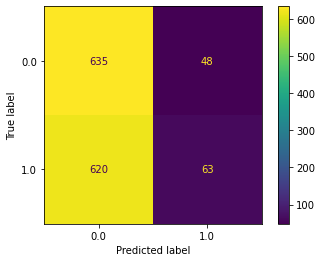

<IPython.core.display.Javascript object>

In [80]:
plot_confusion_matrix(ml_pipeline, X_over_test, y_over_test)

In [35]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90       766
         1.0       0.10      0.28      0.14        43

    accuracy                           0.82       809
   macro avg       0.52      0.57      0.52       809
weighted avg       0.91      0.82      0.86       809



<IPython.core.display.Javascript object>

In [39]:
ml_pipeline

Pipeline(steps=[('scaling', MinMaxScaler()),
                ('chi2select',
                 SelectPercentile(percentile=80,
                                  score_func=<function chi2 at 0x7fe9dc322160>)),
                ('rfc',
                 RandomForestClassifier(max_features=0.8, max_samples=0.8,
                                        min_samples_split=4,
                                        n_estimators=200))])

<IPython.core.display.Javascript object>

In [42]:
ml_pipeline = Pipeline(
    steps=[
        ("scaling", MinMaxScaler()),
        ("chi2select", SelectPercentile(score_func=chi2, percentile=80)),
        (
            "rfc",
            RandomForestClassifier(
                n_estimators=200, min_samples_split=4, max_features=0.8, max_samples=0.8
            ),
        ),
    ]
)


params = {
    "chi2select__percentile": [30, 40, 75],
    "rfc__n_estimators": [50, 100, 300],
    "rfc__bootstrap": [True, False],
    "rfc__max_depth": [10, 20, None],
    "rfc__max_samples": [0.8, None],
    "rfc__min_samples_split": [2, 4],
}

grid = GridSearchCV(
    ml_pipeline, param_grid=params, cv=3, scoring="precision", verbose=10
)

grid.fit(X_over, y_over)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3; 1/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 1/3; 1/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.821 total time=   0.1s
[CV 2/3; 1/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 2/3; 1/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.838 total time=   0.1s
[CV 3/3; 1/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 3/3; 1/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10

[CV 3/3; 8/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.828 total time=   0.2s
[CV 1/3; 9/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 1/3; 9/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.835 total time=   0.6s
[CV 2/3; 9/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 2/3; 9/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.860 total time=   0.7s
[CV 3/3; 9/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=N

[CV 1/3; 17/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.850 total time=   0.2s
[CV 2/3; 17/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 2/3; 17/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.849 total time=   0.3s
[CV 3/3; 17/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 3/3; 17/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.842 total time=   0.2s
[CV 1/3; 18/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=

[CV 2/3; 25/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.854 total time=   0.1s
[CV 3/3; 25/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 3/3; 25/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.857 total time=   0.1s
[CV 1/3; 26/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 1/3; 26/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.854 total time=   0.2s
[CV 2/3; 26/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max

[CV 2/3; 33/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.860 total time=   0.8s
[CV 3/3; 33/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 3/3; 33/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.860 total time=   0.8s
[CV 1/3; 34/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=50
[CV 1/3; 34/216] END chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.861 total time=   0.1s
[CV 2/3; 34/216] START chi2select__percentile=30, rfc__bootstrap=True, rfc__max_depth=None, rf

[CV 2/3; 41/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.840 total time=   0.3s
[CV 3/3; 41/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 3/3; 41/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.829 total time=   0.3s
[CV 1/3; 42/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 1/3; 42/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.747 total time=   0.8s
[CV 2/3; 42/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_sa

[CV 2/3; 49/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.857 total time=   0.2s
[CV 3/3; 49/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 3/3; 49/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.858 total time=   0.2s
[CV 1/3; 50/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 1/3; 50/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.835 total time=   0.3s
[CV 2/3; 50/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_sampl

[CV 2/3; 57/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.862 total time=   1.1s
[CV 3/3; 57/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 3/3; 57/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.860 total time=   1.0s
[CV 1/3; 58/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=50
[CV 1/3; 58/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.841 total time=   0.2s
[CV 2/3; 58/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=20, rfc__max

[CV 2/3; 65/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.855 total time=   0.4s
[CV 3/3; 65/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 3/3; 65/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.862 total time=   0.3s
[CV 1/3; 66/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 1/3; 66/216] END chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.845 total time=   1.0s
[CV 2/3; 66/216] START chi2select__percentile=30, rfc__bootstrap=False, rfc__max_depth=None,

[CV 2/3; 73/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.858 total time=   0.1s
[CV 3/3; 73/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 3/3; 73/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.842 total time=   0.1s
[CV 1/3; 74/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 1/3; 74/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.856 total time=   0.3s
[CV 2/3; 74/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=0.8

[CV 2/3; 81/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.854 total time=   0.8s
[CV 3/3; 81/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 3/3; 81/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.873 total time=   0.9s
[CV 1/3; 82/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=50
[CV 1/3; 82/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.842 total time=   0.1s
[CV 2/3; 82/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_sampl

[CV 2/3; 89/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.847 total time=   0.3s
[CV 3/3; 89/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 3/3; 89/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.891 total time=   0.3s
[CV 1/3; 90/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 1/3; 90/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.885 total time=   0.9s
[CV 2/3; 90/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=

[CV 2/3; 97/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.863 total time=   0.2s
[CV 3/3; 97/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 3/3; 97/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.906 total time=   0.2s
[CV 1/3; 98/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 1/3; 98/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.885 total time=   0.3s
[CV 2/3; 98/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max

[CV 1/3; 105/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.899 total time=   1.0s
[CV 2/3; 105/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 2/3; 105/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.878 total time=   1.0s
[CV 3/3; 105/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 3/3; 105/216] END chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.911 total time=   1.0s
[CV 1/3; 106/216] START chi2select__percentile=40, rfc__bootstrap=True, rfc__max_depth=

[CV 3/3; 112/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.834 total time=   0.2s
[CV 1/3; 113/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 1/3; 113/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.802 total time=   0.4s
[CV 2/3; 113/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 2/3; 113/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.852 total time=   0.4s
[CV 3/3; 113/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=10, rfc__m

[CV 3/3; 120/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.840 total time=   1.2s
[CV 1/3; 121/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 1/3; 121/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.881 total time=   0.2s
[CV 2/3; 121/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 2/3; 121/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.871 total time=   0.2s
[CV 3/3; 121/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max

[CV 3/3; 128/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.894 total time=   0.5s
[CV 1/3; 129/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 1/3; 129/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.885 total time=   1.5s
[CV 2/3; 129/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 2/3; 129/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.868 total time=   1.7s
[CV 3/3; 129/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=20, 

[CV 2/3; 136/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.868 total time=   0.2s
[CV 3/3; 136/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50
[CV 3/3; 136/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.909 total time=   0.2s
[CV 1/3; 137/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 1/3; 137/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.885 total time=   0.4s
[CV 2/3; 137/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=No

[CV 1/3; 144/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.885 total time=   1.3s
[CV 2/3; 144/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 2/3; 144/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.871 total time=   1.3s
[CV 3/3; 144/216] START chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 3/3; 144/216] END chi2select__percentile=40, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.897 total time=   1.4s
[CV 1/3; 145/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_d

[CV 1/3; 152/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.880 total time=   0.5s
[CV 2/3; 152/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 2/3; 152/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.890 total time=   0.5s
[CV 3/3; 152/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 3/3; 152/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.904 total time=   0.5s
[CV 1/3; 153/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=10, rfc__m

[CV 1/3; 160/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.921 total time=   0.3s
[CV 2/3; 160/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50
[CV 2/3; 160/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.911 total time=   0.3s
[CV 3/3; 160/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50
[CV 3/3; 160/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.926 total time=   0.3s
[CV 1/3; 161/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples

[CV 1/3; 168/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.944 total time=   1.8s
[CV 2/3; 168/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 2/3; 168/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.939 total time=   1.7s
[CV 3/3; 168/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 3/3; 168/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.943 total time=   1.7s
[CV 1/3; 169/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=None, rfc_

[CV 3/3; 175/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.935 total time=   0.3s
[CV 1/3; 176/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 1/3; 176/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.942 total time=   0.6s
[CV 2/3; 176/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 2/3; 176/216] END chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.933 total time=   0.6s
[CV 3/3; 176/216] START chi2select__percentile=75, rfc__bootstrap=True, rfc__max_depth=N

[CV 2/3; 183/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.855 total time=   1.9s
[CV 3/3; 183/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 3/3; 183/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.852 total time=   2.0s
[CV 1/3; 184/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50
[CV 1/3; 184/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=0.8, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.836 total time=   0.3s
[CV 2/3; 184/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__ma

[CV 2/3; 191/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.852 total time=   0.7s
[CV 3/3; 191/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 3/3; 191/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.853 total time=   0.7s
[CV 1/3; 192/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300
[CV 1/3; 192/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=300;, score=0.838 total time=   2.1s
[CV 2/3; 192/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=10, 

[CV 2/3; 199/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.906 total time=   0.4s
[CV 3/3; 199/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=50
[CV 3/3; 199/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.913 total time=   0.4s
[CV 1/3; 200/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100
[CV 1/3; 200/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=20, rfc__max_samples=None, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.915 total time=   0.9s
[CV 2/3; 200/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=20, rfc

[CV 1/3; 207/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.924 total time=   2.7s
[CV 2/3; 207/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 2/3; 207/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.917 total time=   2.5s
[CV 3/3; 207/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300
[CV 3/3; 207/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=0.8, rfc__min_samples_split=2, rfc__n_estimators=300;, score=0.918 total time=   2.5s
[CV 1/3; 208/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth

[CV 3/3; 214/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.926 total time=   0.4s
[CV 1/3; 215/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 1/3; 215/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.913 total time=   0.9s
[CV 2/3; 215/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=100
[CV 2/3; 215/216] END chi2select__percentile=75, rfc__bootstrap=False, rfc__max_depth=None, rfc__max_samples=None, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.902 total time=   0.8s
[CV 3/3; 215/216] START chi2select__percentile=75, rfc__bootstrap=False, rfc__max_d

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaling', MinMaxScaler()),
                                       ('chi2select',
                                        SelectPercentile(percentile=80,
                                                         score_func=<function chi2 at 0x7fe9dc322160>)),
                                       ('rfc',
                                        RandomForestClassifier(max_features=0.8,
                                                               max_samples=0.8,
                                                               min_samples_split=4,
                                                               n_estimators=200))]),
             param_grid={'chi2select__percentile': [30, 40, 75],
                         'rfc__bootstrap': [True, False],
                         'rfc__max_depth': [10, 20, None],
                         'rfc__max_samples': [0.8, None],
                         'rfc__min_samples_split': [2, 4],
                         'rfc__n_estimators': [50, 100, 300]},
             scoring='precision', verbose=10)

<IPython.core.display.Javascript object>

In [44]:
grid.best_params_

{'chi2select__percentile': 75,
 'rfc__bootstrap': True,
 'rfc__max_depth': None,
 'rfc__max_samples': None,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 300}

<IPython.core.display.Javascript object>

In [49]:
y_pred_grid = grid.best_estimator_.predict(X_test)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.90       779
         1.0       0.06      0.23      0.09        30

    accuracy                           0.82       809
   macro avg       0.51      0.54      0.50       809
weighted avg       0.93      0.82      0.87       809



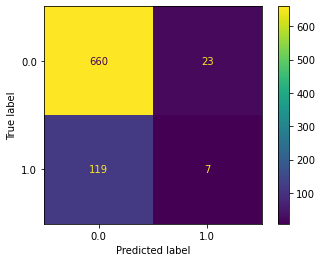

<IPython.core.display.Javascript object>

In [53]:
plot_confusion_matrix(grid.best_estimator_, X_test, y_test)
print(classification_report(y_pred_grid, y_test))

In [74]:
ml_pipeline = Pipeline(
    steps=[
        ("scaling", MinMaxScaler()),
        ("chi2select", SelectPercentile(score_func=chi2, percentile=30)),
        ("rfc", RandomForestClassifier(n_estimators=300, min_samples_split=5),),
    ]
)

<IPython.core.display.Javascript object>

In [75]:
# ml_pipeline.fit(X_over, y_over)
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaling', MinMaxScaler()),
                ('chi2select',
                 SelectPercentile(percentile=30,
                                  score_func=<function chi2 at 0x7fe9dc322160>)),
                ('rfc',
                 RandomForestClassifier(min_samples_split=5,
                                        n_estimators=300))])

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.90       779
         1.0       0.06      0.23      0.09        30

    accuracy                           0.82       809
   macro avg       0.51      0.54      0.50       809
weighted avg       0.93      0.82      0.87       809



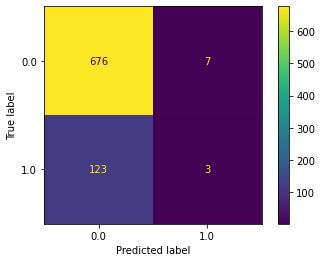

<IPython.core.display.Javascript object>

In [76]:
plot_confusion_matrix(ml_pipeline, X_test, y_test)
print(classification_report(y_pred_grid, y_test))